In [1]:
cd ../analysis/

/home/jlee782/final_segmentation/analysis


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from ast import literal_eval as make_tuple
from utils import * 
from sample_worker_seeds import sample_specs
import glob
sample_lst = sample_specs.keys()
obj_clusters = clusters()
object_lst = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 42, 43, 44, 45, 46, 47]

/home/jlee782/.local/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [4]:
clust_df = pd.read_csv("spectral_clustering_all_hard_obj.csv")
clustObj = clust_df.objid.unique() 
noClust_obj =[obj for obj in object_lst if obj not in clustObj]

In [5]:
base="MV"
df_data=[]
for k in range(100,550,50):
    for objid in object_lst: #range(1, 2):
        for batch in sample_lst:
            if str(objid) in obj_clusters[batch]:
                clusts = ["-1"] + [obj_clusters[batch][str(objid)]]
            else:
                clusts = ["-1"]
            for clust in clusts:
                hydir = '{}{}/obj{}/hybrid/{}/'.format(PIXEL_EM_DIR, batch, objid, k)
                #print hydir
                for ecglobpath in glob.glob(hydir+"/*"):
                    expand_thresh, contract_thresh = make_tuple(ecglobpath.split("/")[-1])
                    hybriddir = hybrid_dir(batch, objid, k, expand_thresh, contract_thresh)
                    prj_file = hybriddir+"/{}_{}_hybrid_prj.json".format(base,clust)
                    if clust=="-1":
                        mv_p,mv_r,mv_j = json.load(open(hybriddir.split("hybrid")[0]+"MV_prj.json"))
                    else:
                        mv_p,mv_r,mv_j = json.load(open(hybriddir.split("hybrid")[0]+"/clust{}/MV_prj.json".format(clust)))
                    if os.path.exists(prj_file):
                        p,r,j = json.load(open(prj_file))
                        df_data.append([batch, objid,clust, k, expand_thresh, contract_thresh,p,r,j,mv_p,mv_r,mv_j])
                    else:
                        print "no file:",prj_file

df = pd.DataFrame(df_data,columns=["sample","objid","clust","k","expand_thresh","contract_thresh","p","r","j","mv_p","mv_r","mv_j"])
df["num_workers"] = df["sample"].apply(lambda x: int(x.split("workers")[0]))
df["diff_p"]=df["p"]-df["mv_p"]
df["diff_r"]=df["r"]-df["mv_r"]
df["diff_j"]=df["j"]-df["mv_j"]

In [6]:
df.to_csv("vision_MV.csv",index=None)

In [9]:
# df[(df["objid"]==42)&(df["clust"]=='-1')&(df["sample"]=="25workers_rand0")]

In [10]:
def plot_diff_prj(k,e,c):
    plt.figure()
    select_df = df[(df["k"]==k)&(df["expand_thresh"]==e)&(df["contract_thresh"]==c)]#&(df["clust"]=="-1")]
    plt.title("Difference b/w Vision filled PRJ v.s no-fill PRJ: k={} ; [e,c]=[{},{}]".format(k,e,c))
    plt.plot(select_df.groupby("num_workers").mean()["diff_p"],"-o")
    plt.plot(select_df.groupby("num_workers").mean()["diff_r"],"-o")
    plt.plot(select_df.groupby("num_workers").mean()["diff_j"],"-o")
    plt.xlabel("Nworkers")
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

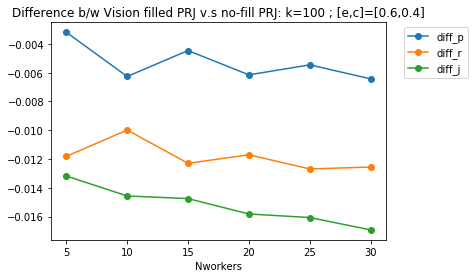

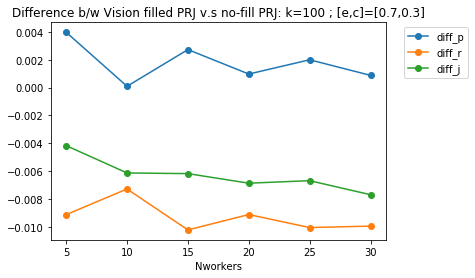

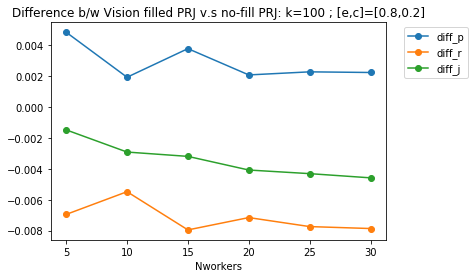

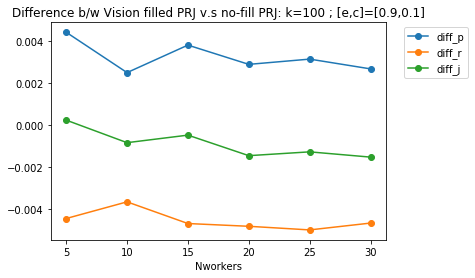

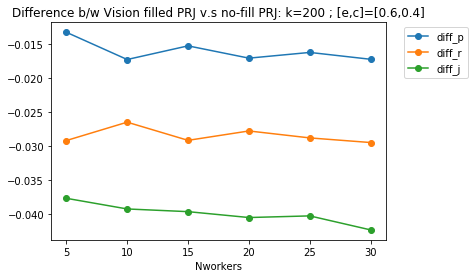

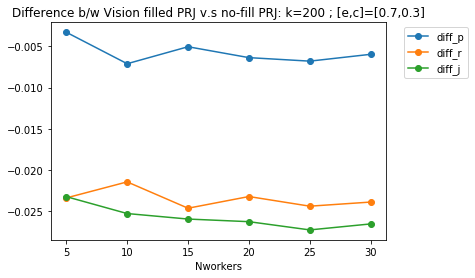

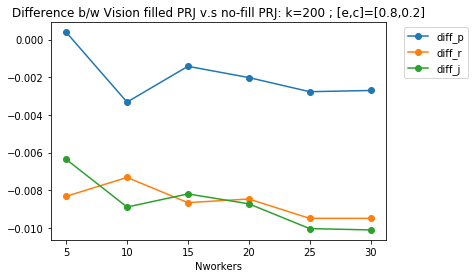

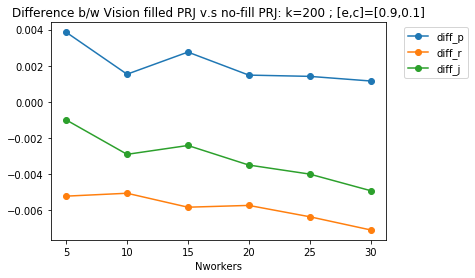

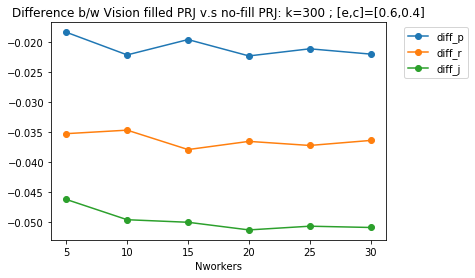

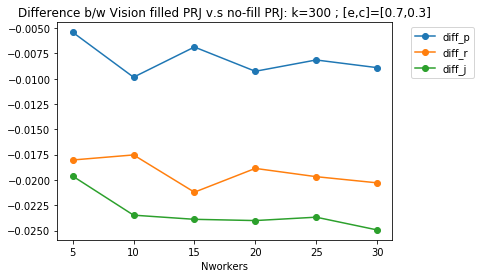

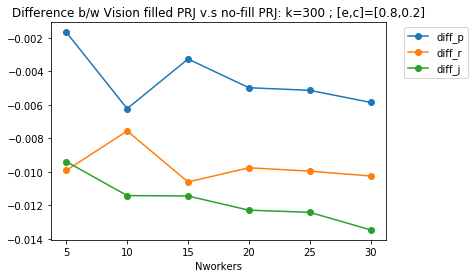

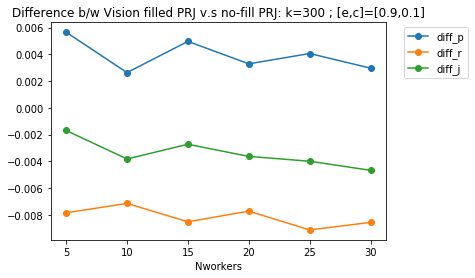

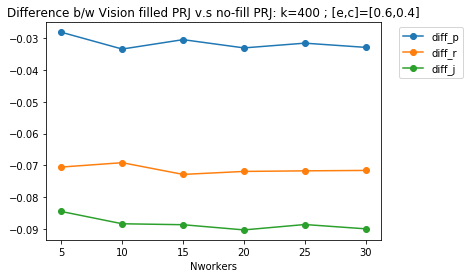

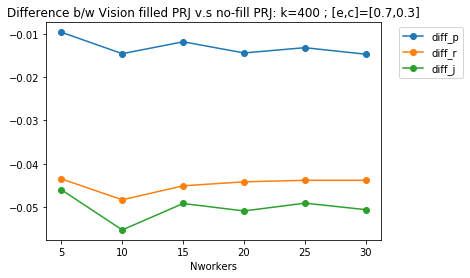

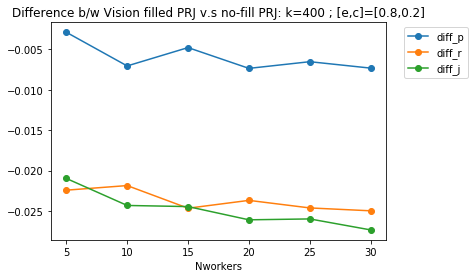

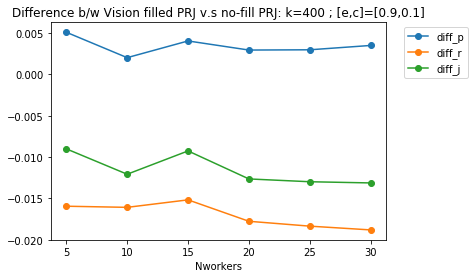

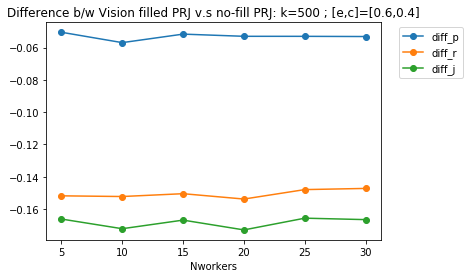

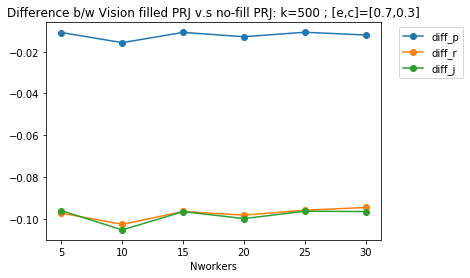

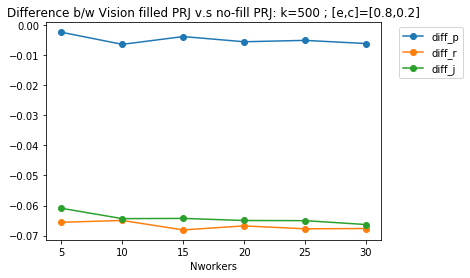

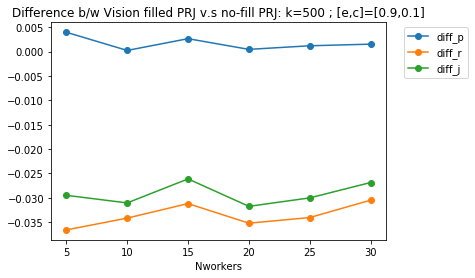

In [11]:
ec_threshs=[(0.6,0.4),(0.7,0.3),(0.8,0.2),(0.9,0.1)]
for k in range(100, 550, 100):
    for ec_thresh in ec_threshs:
        e = ec_thresh[0]
        c = ec_thresh[1]
        plot_diff_prj(k,e,c)

Filling yields better performance:  30.0987000481 %
Filling yields worse performance: 69.8892633606 %
Filling yields same performance: 0.0120365912374 %


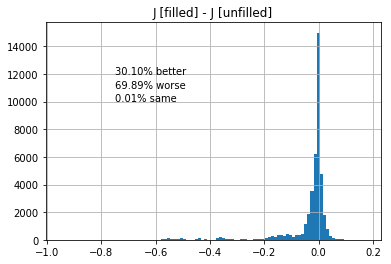

In [12]:
hist = df["diff_j"].hist(bins=100)
plt.title("J [filled] - J [unfilled]")
print "Filling yields better performance: ",len(df[df["diff_j"]>0])/float(len(df))*100 ,"%"
print "Filling yields worse performance:",len(df[df["diff_j"]<0])/float(len(df))*100 ,"%"
print "Filling yields same performance:",len(df[df["diff_j"]==0])/float(len(df))*100 ,"%"
plt.text(-0.75,12000,"{:.2f}% better".format(len(df[df["diff_j"]>0])/float(len(df))*100))
plt.text(-0.75,11000,"{:.2f}% worse".format(len(df[df["diff_j"]<0])/float(len(df))*100))
plt.text(-0.75,10000,"{:.2f}% same".format(len(df[df["diff_j"]==0])/float(len(df))*100))

In [36]:
def plot_diff_prj_histo(k,e,c):
    plt.figure()
    select_df = df[(df["k"]==k)&(df["expand_thresh"]==e)&(df["contract_thresh"]==c)]#&(df["clust"]=="-1")]
    hist = select_df["diff_j"].hist(bins=100)
    plt.title("J [filled] - J [unfilled]: k={} ; [e,c]=[{},{}]".format(k,e,c))
    plt.text(-0.08,150,"{:.2f}% better".format(len(select_df[select_df["diff_j"]>0])/float(len(select_df))*100))
    plt.text(-0.08,130,"{:.2f}% worse".format(len(select_df[select_df["diff_j"]<0])/float(len(select_df))*100))
    plt.text(-0.08,110,"{:.2f}% same".format(len(select_df[select_df["diff_j"]==0])/float(len(select_df))*100))

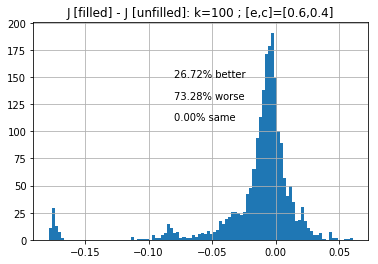

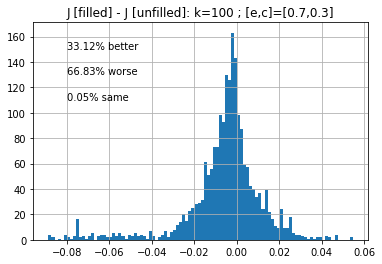

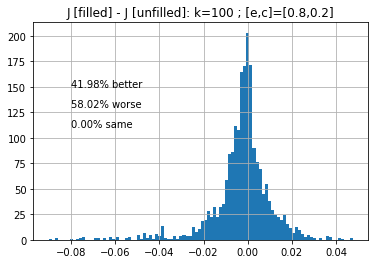

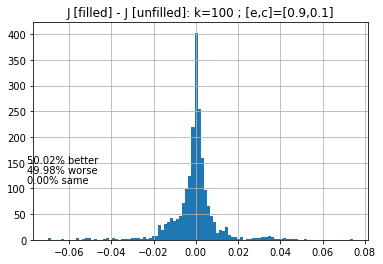

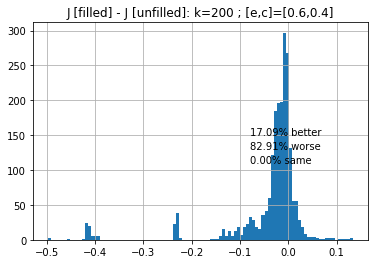

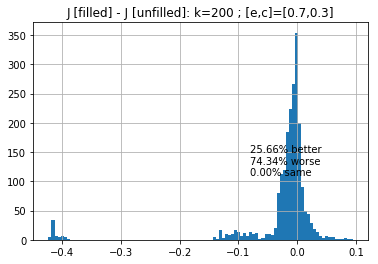

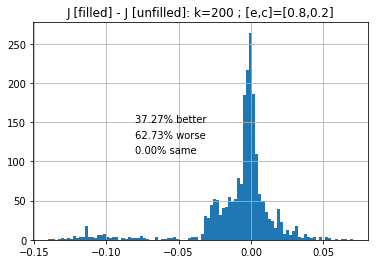

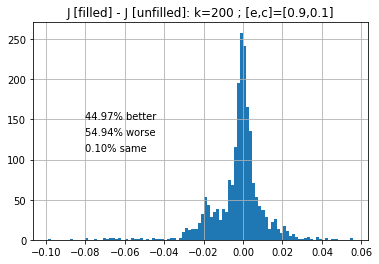

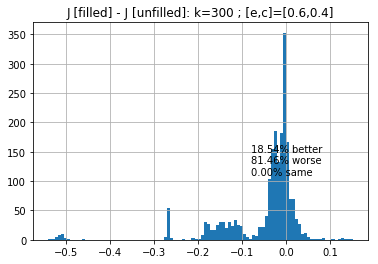

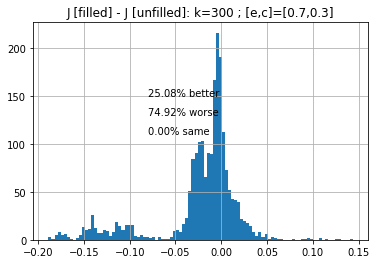

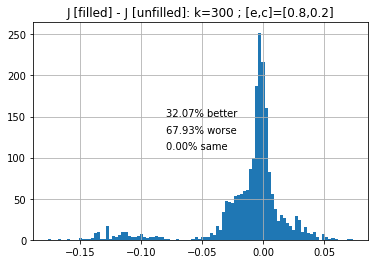

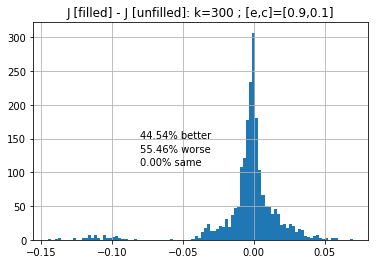

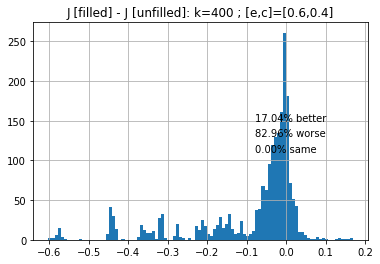

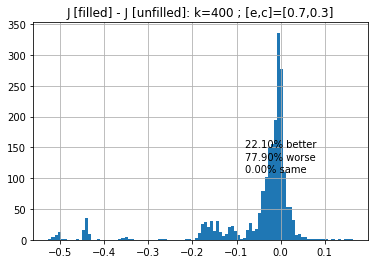

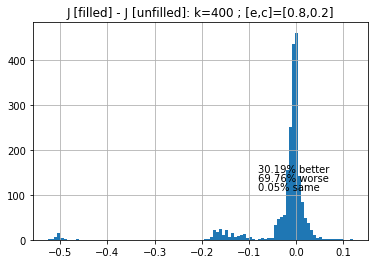

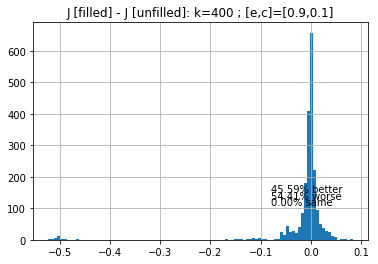

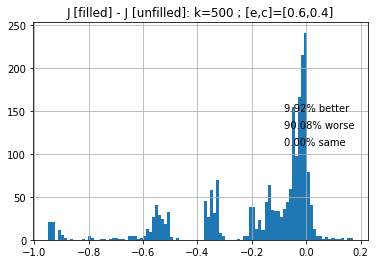

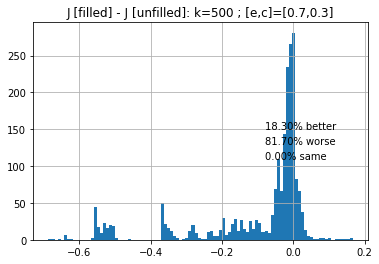

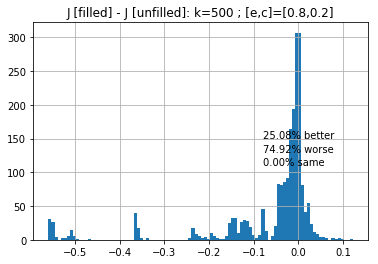

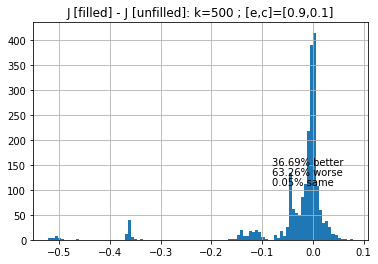

In [37]:
ec_threshs=[(0.6,0.4),(0.7,0.3),(0.8,0.2),(0.9,0.1)]
for k in range(100, 550, 100):
    for ec_thresh in ec_threshs:
        e = ec_thresh[0]
        c = ec_thresh[1]
        plot_diff_prj_histo(k,e,c)

In [15]:
def plot_prj(k,e,c):
    plt.figure()
    select_df = df[(df["k"]==k)&(df["expand_thresh"]==e)&(df["contract_thresh"]==c)]#&(df["clust"]=="-1")]
    plt.title("k={} ; [e,c]=[{},{}]".format(k,e,c))
    plt.plot(select_df.groupby("num_workers").mean()["p"],"-o",label="filled p",color="blue")
    plt.plot(select_df.groupby("num_workers").mean()["r"],"-o",label="filled r",color="orange")
    plt.plot(select_df.groupby("num_workers").mean()["j"],"-o",label="filled j",color="green")

    plt.plot(select_df.groupby("num_workers").mean()["mv_p"],"--",label="no-fill p",color="blue")
    plt.plot(select_df.groupby("num_workers").mean()["mv_r"],"--",label="no-fill r",color="orange")
    plt.plot(select_df.groupby("num_workers").mean()["mv_j"],"--",label="no-fill j",color="green")
    plt.xlabel("Nworkers")
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

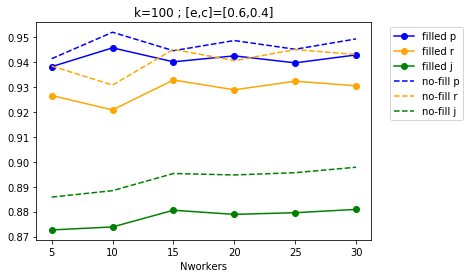

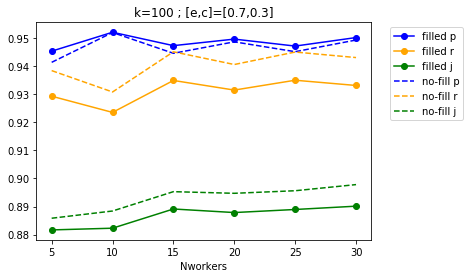

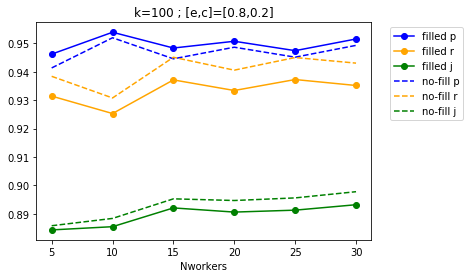

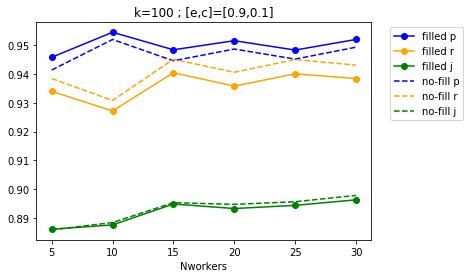

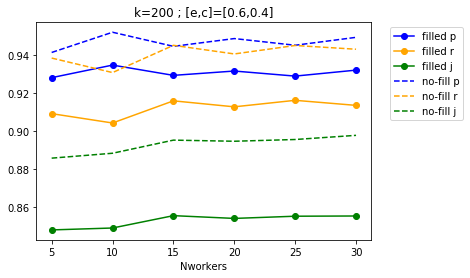

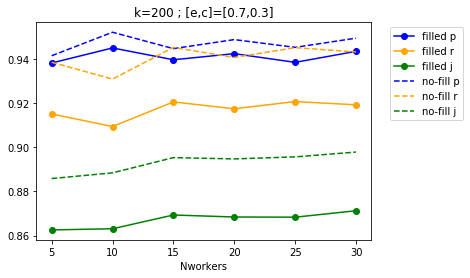

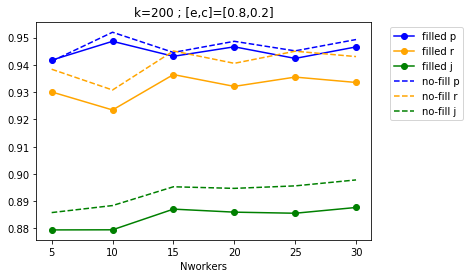

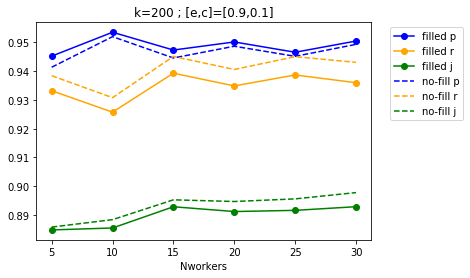

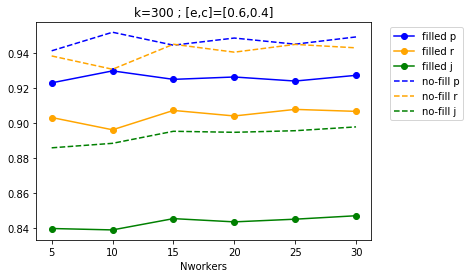

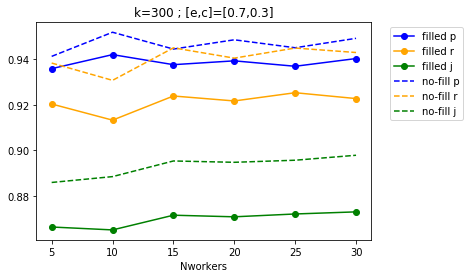

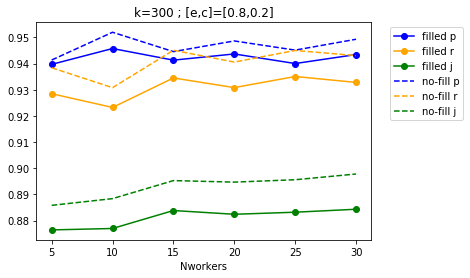

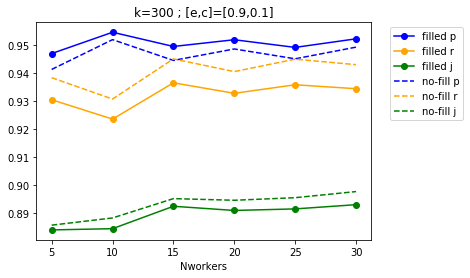

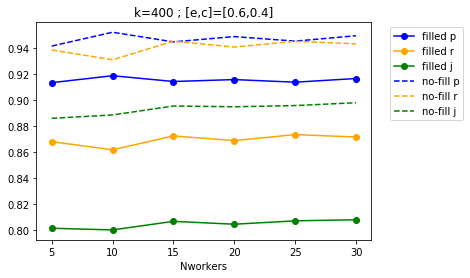

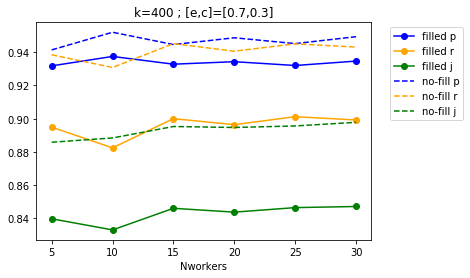

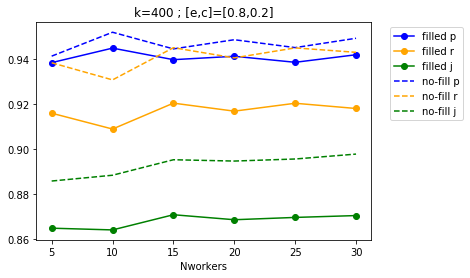

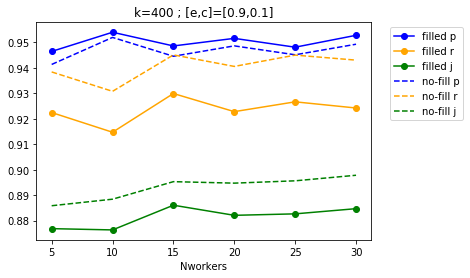

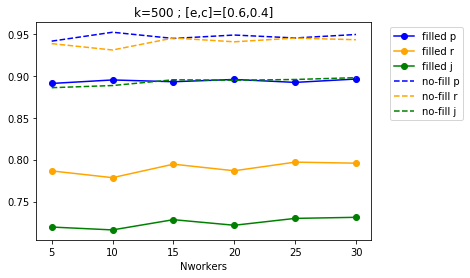

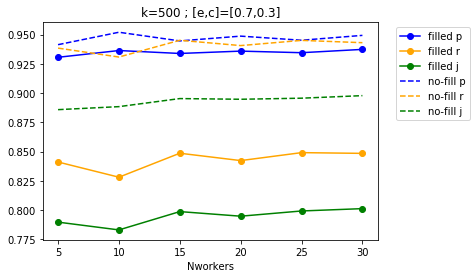

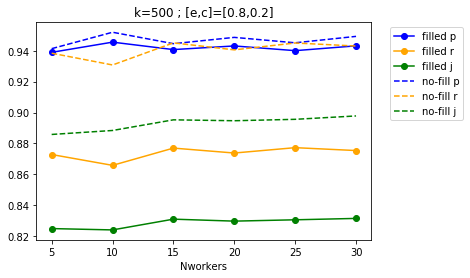

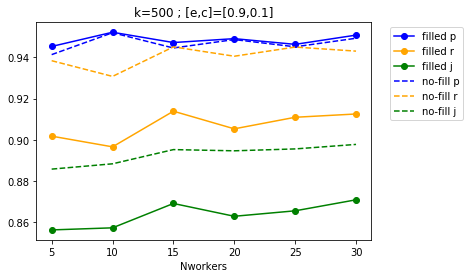

In [16]:
ec_threshs=[(0.6,0.4),(0.7,0.3),(0.8,0.2),(0.9,0.1)]
for k in range(100, 550, 100):
    for ec_thresh in ec_threshs:
        e = ec_thresh[0]
        c = ec_thresh[1]
        plot_prj(k,e,c)

# Choosing the best batch-object

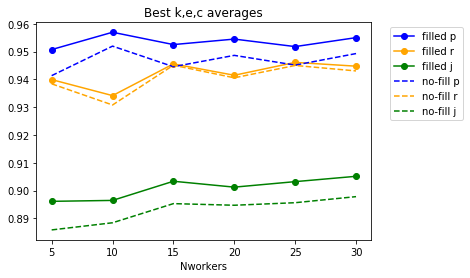

In [17]:
plt.figure()
plt.title("Best k,e,c averages")
select_df = df.loc[df.groupby(["sample","objid","clust"])["j"].idxmax()]
plt.plot(select_df.groupby("num_workers").mean()["p"],"-o",label="filled p",color="blue")
plt.plot(select_df.groupby("num_workers").mean()["r"],"-o",label="filled r",color="orange")
plt.plot(select_df.groupby("num_workers").mean()["j"],"-o",label="filled j",color="green")

plt.plot(select_df.groupby("num_workers").mean()["mv_p"],"--",label="no-fill p",color="blue")
plt.plot(select_df.groupby("num_workers").mean()["mv_r"],"--",label="no-fill r",color="orange")
plt.plot(select_df.groupby("num_workers").mean()["mv_j"],"--",label="no-fill j",color="green")
plt.xlabel("Nworkers")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

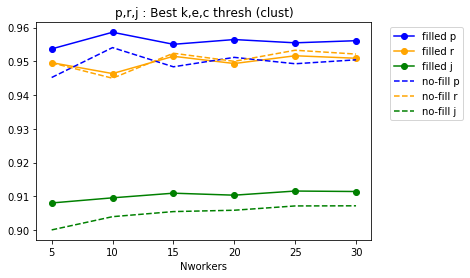

In [18]:
plt.figure()
plt.title("p,r,j : Best k,e,c thresh (clust)")
select_df = df[((df["clust"]=='-1') & (df["objid"].isin(noClust_obj))|((df["clust"]!='-1') & (df["objid"].isin(clustObj))))]
select_df = select_df.loc[select_df.groupby(["sample","objid","clust"])["j"].idxmax()]
plt.plot(select_df.groupby("num_workers").mean()["p"],"-o",label="filled p",color="blue")
plt.plot(select_df.groupby("num_workers").mean()["r"],"-o",label="filled r",color="orange")
plt.plot(select_df.groupby("num_workers").mean()["j"],"-o",label="filled j",color="green")

plt.plot(select_df.groupby("num_workers").mean()["mv_p"],"--",label="no-fill p",color="blue")
plt.plot(select_df.groupby("num_workers").mean()["mv_r"],"--",label="no-fill r",color="orange")
plt.plot(select_df.groupby("num_workers").mean()["mv_j"],"--",label="no-fill j",color="green")
plt.xlabel("Nworkers")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

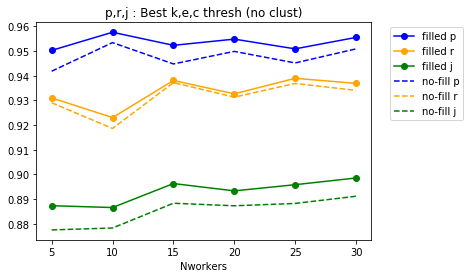

In [19]:
plt.figure()
plt.title("p,r,j : Best k,e,c thresh (no clust)")
select_df = df[(df["clust"]=='-1')]
select_df = select_df.loc[select_df.groupby(["sample","objid","clust"])["j"].idxmax()]
plt.plot(select_df.groupby("num_workers").mean()["p"],"-o",label="filled p",color="blue")
plt.plot(select_df.groupby("num_workers").mean()["r"],"-o",label="filled r",color="orange")
plt.plot(select_df.groupby("num_workers").mean()["j"],"-o",label="filled j",color="green")

plt.plot(select_df.groupby("num_workers").mean()["mv_p"],"--",label="no-fill p",color="blue")
plt.plot(select_df.groupby("num_workers").mean()["mv_r"],"--",label="no-fill r",color="orange")
plt.plot(select_df.groupby("num_workers").mean()["mv_j"],"--",label="no-fill j",color="green")
plt.xlabel("Nworkers")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

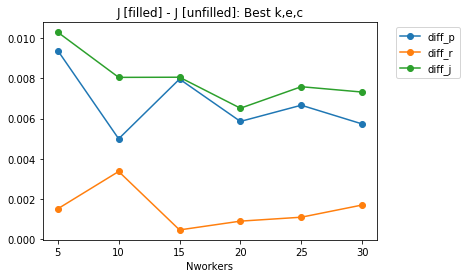

In [29]:
plt.figure()
plt.title("J [filled] - J [unfilled]: Best k,e,c")
select_df = df.loc[df.groupby(["sample","objid","clust"])["j"].idxmax()]
plt.plot(select_df.groupby("num_workers").mean()["diff_p"],"-o")
plt.plot(select_df.groupby("num_workers").mean()["diff_r"],"-o")
plt.plot(select_df.groupby("num_workers").mean()["diff_j"],"-o")
plt.xlabel("Nworkers")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

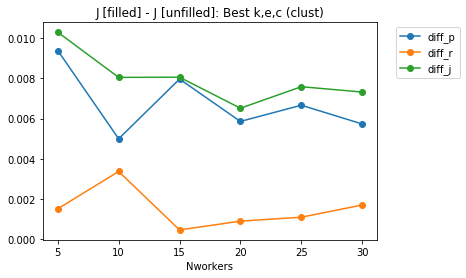

In [28]:
plt.figure()
plt.title("J [filled] - J [unfilled]: Best k,e,c (clust)")
select_df = df[((df["clust"]=='-1') & (df["objid"].isin(noClust_obj))|((df["clust"]!='-1') & (df["objid"].isin(clustObj))))]
select_df = df.loc[df.groupby(["sample","objid","clust"])["j"].idxmax()]
plt.plot(select_df.groupby("num_workers").mean()["diff_p"],"-o")
plt.plot(select_df.groupby("num_workers").mean()["diff_r"],"-o")
plt.plot(select_df.groupby("num_workers").mean()["diff_j"],"-o")
plt.xlabel("Nworkers")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")


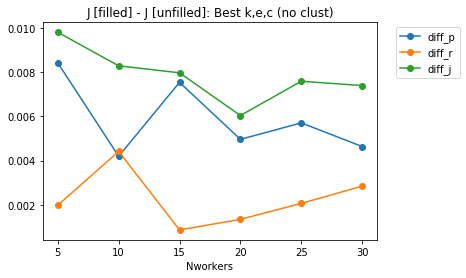

In [27]:
plt.figure()
plt.title("J [filled] - J [unfilled]: Best k,e,c (no clust)")
select_df = df[(df["clust"]=='-1')]
select_df = select_df.loc[select_df.groupby(["sample","objid","clust"])["j"].idxmax()]
plt.plot(select_df.groupby("num_workers").mean()["diff_p"],"-o")
plt.plot(select_df.groupby("num_workers").mean()["diff_r"],"-o")
plt.plot(select_df.groupby("num_workers").mean()["diff_j"],"-o")
plt.xlabel("Nworkers")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

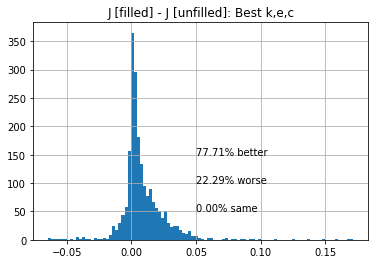

In [24]:
plt.figure()
plt.title("J [filled] - J [unfilled]: Best k,e,c")
select_df = df.loc[df.groupby(["sample","objid","clust"])["j"].idxmax()]
hist = select_df["diff_j"].hist(bins=100)
plt.text(0.05,150,"{:.2f}% better".format(len(select_df[select_df["diff_j"]>0])/float(len(select_df))*100))
plt.text(0.05,100,"{:.2f}% worse".format(len(select_df[select_df["diff_j"]<0])/float(len(select_df))*100))
plt.text(0.05,50,"{:.2f}% same".format(len(select_df[select_df["diff_j"]==0])/float(len(select_df))*100))

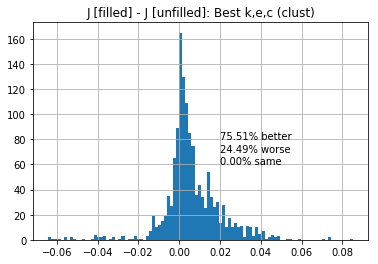

In [26]:
plt.figure()
plt.title("J [filled] - J [unfilled]: Best k,e,c (clust)")
select_df = df[((df["clust"]=='-1') & (df["objid"].isin(noClust_obj))|((df["clust"]!='-1') & (df["objid"].isin(clustObj))))]
select_df = select_df.loc[select_df.groupby(["sample","objid","clust"])["j"].idxmax()]
hist = select_df["diff_j"].hist(bins=100)
plt.text(0.02,80,"{:.2f}% better".format(len(select_df[select_df["diff_j"]>0])/float(len(select_df))*100))
plt.text(0.02,70,"{:.2f}% worse".format(len(select_df[select_df["diff_j"]<0])/float(len(select_df))*100))
plt.text(0.02,60,"{:.2f}% same".format(len(select_df[select_df["diff_j"]==0])/float(len(select_df))*100))

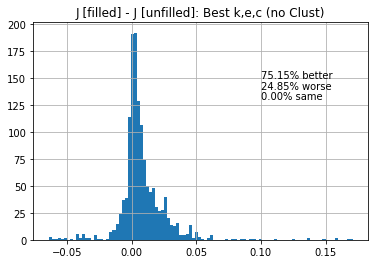

In [38]:
plt.figure()
plt.title("J [filled] - J [unfilled]: Best k,e,c (no Clust)")
select_df = df[df["clust"]=='-1']
select_df = select_df.loc[select_df.groupby(["sample","objid","clust"])["j"].idxmax()]
hist = select_df["diff_j"].hist(bins=100)
plt.text(0.1,150,"{:.2f}% better".format(len(select_df[select_df["diff_j"]>0])/float(len(select_df))*100))
plt.text(0.1,140,"{:.2f}% worse".format(len(select_df[select_df["diff_j"]<0])/float(len(select_df))*100))
plt.text(0.1,130,"{:.2f}% same".format(len(select_df[select_df["diff_j"]==0])/float(len(select_df))*100))

-----------------------------------------------------------------------------------------------

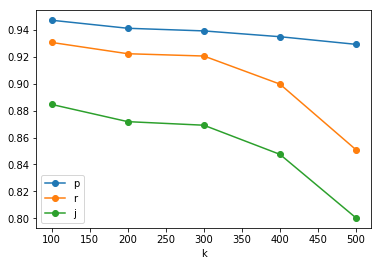

In [74]:
#why does p,r not cross over? because of mean? 
plt.plot(df.groupby("k").mean()["p"],"-o")
plt.plot(df.groupby("k").mean()["r"],"-o")
plt.plot(df.groupby("k").mean()["j"],"-o")
plt.xlabel("k")
plt.legend()

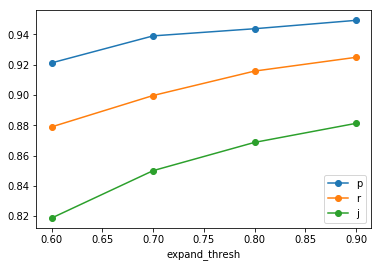

In [75]:
plt.plot(df.groupby("expand_thresh").mean()["p"],"-o")
plt.plot(df.groupby("expand_thresh").mean()["r"],"-o")
plt.plot(df.groupby("expand_thresh").mean()["j"],"-o")
plt.xlabel("expand_thresh")
plt.legend()

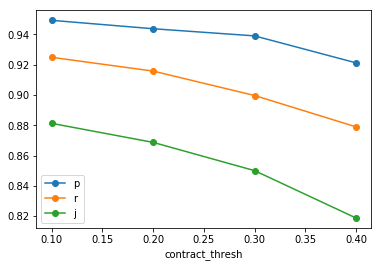

In [76]:
x=  "contract_thresh"
plt.plot(df.groupby(x).mean()["p"],"-o")
plt.plot(df.groupby(x).mean()["r"],"-o")
plt.plot(df.groupby(x).mean()["j"],"-o")
plt.xlabel(x)
plt.legend()

In [60]:
import pickle as pkl
mask = pkl.load(open("pixel_em/25workers_rand0/obj1/hybrid/100/(0.6,0.4)/MV_-1_hybrid_mask.pkl"))

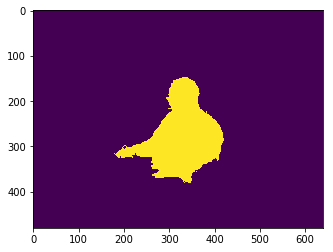

In [61]:
plt.imshow(mask)